In [1]:
import calendar 
from collections import Counter
import enchant
import h3
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np 
import os
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import random
import re 
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import textblob
import sys
from textblob.sentiments import NaiveBayesAnalyzer
from textblob import TextBlob, Word
from wordcloud import STOPWORDS, WordCloud
import xgboost as xgb
from xgboost import XGBRegressor

import warnings 
warnings.filterwarnings('ignore')

## Introduction.

As a freelancer and Michelin trained chef for around 25 years, I worked in over 200 different hotels, restaurants, and private family residences such as castles, yachts and mansions, so it's fair to say I have seen my share of hotels of all sizes and qualities (for my sins).  Admittedly I was never a huge fan of review sites because I know that people can and will leave negative reviews for things that are out of a stakeholder's control, but I am also interested in human nature and curious about the motivations behind customers who leave reviews of a certain polarity as well as being appreciative of the more accurate, constructive criticism some of the review sites provide amid the rough.  I will probably concentrate more on the negative reviews in a bid to uproot issues, or at least explore possible business optimisation opportunities via the medium of NLP. 

Thanks for reading, and please note that this isn't a professional project, this is me truffling through data for fun when I was learning NLP, as well as investigating for no other reason than to see what I can come up with.  This means there will be little in the way of structure, and probably even less in the way of professionalism & common sense.  

In [2]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df = pd.read_csv("/work/Datafiniti_Hotel_Reviews_Jun19.csv")

## The data.

In [4]:
print(f'Dataframe size: {round(sys.getsizeof(df) / (1024 * 1024), 1)} MB. ')

Dataframe size: 130.5 MB. 


In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### A quick peek.

A quick look at the dataframe shows a whole bunch of columns I want to drop.  The URLS could come in handy for other projects but for this one I would rather stay on topic and drop them from this project.  My first thought was that I could perhaps take the company name from the URL to use in this project but some URLs are full of utter chaff that will result in way too much work for a fun side project

In [6]:
df.head()

,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,...,reviews.dateSeen,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sourceURLs,websites
0,AWE2FvX5RxPSIh2RscTK,2018-01-18T18:43:12Z,2019-05-20T23:55:47Z,5620 Calle Real,"Hotels,Hotels and motels,Hotel and motel mgmt....",Accommodation & Food Services,Goleta,US,us/ca/goleta/5620callereal/-1127060008,34.44178,...,2018-01-03T00:00:00Z,3,https://www.tripadvisor.com/Hotel_Review-g3243...,"This hotel was nice and quiet. Did not know, t...",Best Western Plus Hotel,San Jose,UnitedStates,tatsurok2018,https://www.tripadvisor.com/Hotel_Review-g3243...,https://www.bestwestern.com/en_US/book/hotel-r...
1,AVwcj_OhkufWRAb5wi9T,2016-11-06T20:21:05Z,2019-05-20T23:31:56Z,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,...,2016-10-09T00:00:00Z,4,https://www.tripadvisor.com/Hotel_Review-g3217...,We stayed in the king suite with the separatio...,Clean rooms at solid rates in the heart of Carmel,San Francisco,CA,STEPHEN N,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com
2,AVwcj_OhkufWRAb5wi9T,2016-11-06T20:21:05Z,2019-05-20T23:31:56Z,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,...,2016-10-09T00:00:00Z,3,https://www.tripadvisor.com/Hotel_Review-g3217...,"Parking was horrible, somebody ran into my ren...",Business,Prescott Valley,AZ,15Deborah,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com
3,AVwcj_OhkufWRAb5wi9T,2016-11-06T20:21:05Z,2019-05-20T23:31:56Z,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,...,2016-10-31T00:00:00Z,5,https://www.tripadvisor.com/Hotel_Review-g3217...,Not cheap but excellent location. Price is som...,Very good,Guaynabo,PR,Wilfredo M,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com
4,AVwcj_OhkufWRAb5wi9T,2016-11-06T20:21:05Z,2019-05-20T23:31:56Z,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,...,"2016-10-09T00:00:00Z,2016-03-27T00:00:00Z",2,https://www.tripadvisor.com/Hotel_Review-g3217...,If you get the room that they advertised on th...,Low chance to come back here,Reno,NV,Luc D,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com


### All of the column labels.

In [7]:
for x in df.columns:
    print(x)

id
dateAdded
dateUpdated
address
categories
primaryCategories
city
country
keys
latitude
longitude
name
postalCode
province
reviews.date
reviews.dateAdded
reviews.dateSeen
reviews.rating
reviews.sourceURLs
reviews.text
reviews.title
reviews.userCity
reviews.userProvince
reviews.username
sourceURLs
websites


1000 missing features exist in a column I would rather not keep anyway, as well as 2 missing in another column I initially didn't want to keep.  There is only one value missing in the 'title' column. 

In [8]:
df.isnull().sum()

id                          0
dateAdded                   0
dateUpdated                 0
address                     0
categories                  0
primaryCategories           0
city                        0
country                     0
keys                        0
latitude                    0
longitude                   0
name                        0
postalCode                  0
province                    0
reviews.date                0
reviews.dateAdded       10000
reviews.dateSeen            0
reviews.rating              0
reviews.sourceURLs          0
reviews.text                0
reviews.title               1
reviews.userCity            0
reviews.userProvince        2
reviews.username            0
sourceURLs                  0
websites                    0
dtype: int64

In [9]:
df = df.drop(['id', 'address', 'country', 'dateAdded', 'dateUpdated', 'categories', 'primaryCategories', 'keys', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.sourceURLs', 'reviews.userProvince', 'sourceURLs', 'websites'], axis=1)

Cleaning the column names - changing camelCase because this isn't JS :-) and getting rid of full stops:

In [10]:
df.columns = [col.replace('.', '_').replace(' ', '_').lower() for col in df.columns]

### Statistical description.

The mean review score across the dataset isn't too bad, sitting at 4.084 I dare say there isn't going to be a massive amount of negative reviews.

In [11]:
df.reviews_rating.describe()

count    10000.000000
mean         4.084100
std          1.152371
min          1.000000
25%          4.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: reviews_rating, dtype: float64

Pulling the review with the empty title column.

In [12]:
df[df['reviews_title'].isnull() & df['reviews_text'].notnull()][['reviews_title', 'reviews_text']]

,reviews_title,reviews_text
4768,NaN,Staffs and service were excellent. I will defi...


As it's a positive review I will fill in the title with something positive, containing similar generic words relative to the review text.

In [13]:
df.reviews_title.fillna('Excellent service and staff, would stay again.', inplace=True)

### Date and time cleaning.

In [14]:
df['reviews_date'] = df['reviews_date'].str.split('T').str[0]
df['reviews_date'] = pd.to_datetime(df['reviews_date'])

In [15]:
df['reviews_year'] = df['reviews_date'].dt.year
df['reviews_month'] = df['reviews_date'].dt.month
df['reviews_day'] = df['reviews_date'].dt.day_name()
df['reviews_quarter'] = df['reviews_date'].dt.quarter

In [16]:
df["reviews_month"] = df["reviews_month"].apply(lambda x: calendar.month_abbr[x])

In [17]:
df.insert(11, 'reviews_date', df.pop('reviews_date'))

In [18]:
df.head()

,city,latitude,longitude,name,postalcode,province,reviews_rating,reviews_text,reviews_title,reviews_usercity,reviews_username,reviews_date,reviews_year,reviews_month,reviews_day,reviews_quarter
0,Goleta,34.44178,-119.81979,Best Western Plus South Coast Inn,93117,CA,3,"This hotel was nice and quiet. Did not know, t...",Best Western Plus Hotel,San Jose,tatsurok2018,2018-01-01,2018,Jan,Monday,1
1,Carmel by the Sea,36.55722,-121.92194,Best Western Carmel's Town House Lodge,93921,CA,4,We stayed in the king suite with the separatio...,Clean rooms at solid rates in the heart of Carmel,San Francisco,STEPHEN N,2016-04-02,2016,Apr,Saturday,2
2,Carmel by the Sea,36.55722,-121.92194,Best Western Carmel's Town House Lodge,93921,CA,3,"Parking was horrible, somebody ran into my ren...",Business,Prescott Valley,15Deborah,2016-01-06,2016,Jan,Wednesday,1
3,Carmel by the Sea,36.55722,-121.92194,Best Western Carmel's Town House Lodge,93921,CA,5,Not cheap but excellent location. Price is som...,Very good,Guaynabo,Wilfredo M,2016-08-22,2016,Aug,Monday,3
4,Carmel by the Sea,36.55722,-121.92194,Best Western Carmel's Town House Lodge,93921,CA,2,If you get the room that they advertised on th...,Low chance to come back here,Reno,Luc D,2016-03-21,2016,Mar,Monday,1


### Categorical description. 

I saved the categorical description until after the datetime cleaning so that those metrics would show up in better detail.

• The Hyatt House Seattle is the most frequently occurring  hotel name.

• San Diego is the top city.

• CA is the top province. 

• New York is the top user city. 

• 'Great Location' is the top review title.

• Monday is the most frequent day for writing reviews.

• July is the most frequent month. 

• And 'Michael M' is our most frequent intrepid explorer.

In [19]:
categorical_table = ff.create_table(df.describe(include=["O"]).T, index=True, index_title="Categorical columns")
iplot(categorical_table)

# Analysis.

First up, a hotel review map box with the hotel /review rating as the marker colour (5* reviews as the light yellow hue, 1* reviews the darker purple hue), and the review title on popup.

In [20]:
fig = px.scatter_mapbox(df, lat="latitude", lon="longitude", width=1000, height=600, center=dict(lat=38.05, lon=-98.5), zoom=2.5, mapbox_style="open-street-map", 
                        hover_data=["reviews_title", "reviews_rating", "name"], title="Hotel review ratings by province", color="reviews_rating", 
                        size="reviews_rating", size_max=15, opacity=0.5)

fig.show()

### Provinces with the highest count of hotels.

California tips the scale for the hotel count by province with a respectable 2647 hotels, over double that of Florida's 1277 hotels in second place, then Georgia holds the third-largest volume of data with 844 hotels:

In [21]:
count_by_province = df.groupby('province')['name'].count().sort_values(ascending=False)

fig = px.bar(count_by_province[:20], x=count_by_province[:20].index, y=count_by_province[:20].values,
                labels={'x':'Province', 'y':'Number of Hotels'}, title='Top 20 Provinces with the most hotels',
                height=400)
fig.update_traces(marker_color='#FFA500')
fig.show()

### Rating distribution.

• The most common review rating is 5, with a count of 4840.  

• Then we see rating 4 with its count of 2849.  

• Rating 3 is third with a count of 1190.  

• Rating 1 is the fourth-most common with a count of 567.

• And finally rating 2 comes in last with a count of 554.  

It's actually quite rare for people to leave 2* reviews, people are either likely to cut a hotel a bit of slack or dunk on it completely (if it isn't positive then it's either neutral (3*) or negative (1*)).

In [22]:
df['reviews_rating'].value_counts() 

fig = px.histogram(df, x="reviews_rating", title='Distribution of reviews_rating', height=400)
fig.update_xaxes(categoryorder='total descending')
fig.show()

### Review distribution by weekday.

• Monday is the most common day for leaving reviews, then it's Tuesday, Wednesday, Sunday, Thursday, Friday and Saturday in that order:

In [23]:
reviews_by_day = df.groupby('reviews_day').count()['reviews_text']

fig = go.Figure(data=[go.Scatter(x=reviews_by_day.index, y=reviews_by_day.values)])
fig.update_layout(title='Reviews by Day', xaxis_title='Day', yaxis_title='Number of Reviews', height=400)
fig.show()

### Review distribution by month. 

• July is the most common month for reviews, followed swiftly by May and August.  

So that's the two peak summer months and then May, the first month of the year that sees anything like decent weather as well as being a month that includes a busy half-term.

In [24]:
fig = px.histogram(df, x="reviews_month", nbins=12, title='Number of reviews per month')
fig.update_layout(xaxis={'categoryorder':'total descending'}, height=400)
fig.update_traces(marker_color='lightblue')
fig.show()

### The highest rated hotels.

• The Hyatt House in Seattle and the Hotel Emma are the two hotels with the highest average rating as seen in blue.   

• The three highest rated hotels in-tow are the French Market Inn, the Grand Hyatt Seattle and the Drury Inn & Suites (New Orleans). 

In [25]:
hotel_rating_high = df.groupby('name')['reviews_rating'].sum().sort_values(ascending=False).head(20)

fig = px.bar(hotel_rating_high, x=hotel_rating_high.index, y=hotel_rating_high.values, color=hotel_rating_high.values, color_continuous_scale='Bluered_r')
fig.update_layout(title='The 20 hotels with the highest total rating', xaxis_title='Hotel Name', yaxis_title='Average Rating', height=400)
fig.show()

### The highest average rated provinces.

The 20 provinces with the highest average ratings.  The top three provinces here are New Mexico, Arkansas and Utah.

In [26]:
province_score = df.groupby('province')['reviews_rating'].mean().sort_values(ascending=False).head(10)
province_score

fig = px.bar(province_score, y=province_score.index, x=province_score.values, color=province_score.values, color_continuous_scale='Oranges')
fig.update_layout(title='The 20 provinces with the highest average rating', xaxis_title='Hotel Name', yaxis_title='Average Rating', height=400)
fig.update_yaxes(autorange="reversed")
fig.show()

### The lowest average rated provinces.

And the 20 provinces with the lowest average rating.  

The bottom three provinces here are Rhode Island, New Jersey and Kentucky.   

This is quite unfair to RI in all honesty, their value count is one single review, which was a 1* review.  NJ has 50 value counts and KY has 60 value counts.  MS has 17 value counts, so it may be worthwhile to remove RI from the top (or bottom) 3 and include MS instead:

In [27]:
province_score_low = df.groupby('province')['reviews_rating'].mean().sort_values(ascending=False).tail(10)
province_score_low

fig = px.bar(province_score_low, y=province_score_low.index, x=province_score_low.values, color=province_score_low.values, color_continuous_scale='Greens')
fig.update_layout(title='The 20 provinces with the lowest average rating', xaxis_title='Hotel Name', yaxis_title='Average Rating', height=400)
fig.update_yaxes(autorange="reversed")
fig.show()

### The top twenty "super-reviewers".

A starburst chart of the top 20 users leaving the most reviews along with the name of the hotels they reviewed, plus the ratings they assigned to those hotels (click on the username in the inner sunburst to see more of that user's reviews).

In [28]:
high_reviewers = df.reviews_username.value_counts().head(20)

fig = px.sunburst(df[df.reviews_username.isin(high_reviewers.index)], path=['reviews_username', 'name'], color='reviews_rating')    
fig.update_layout(height=600, width=800)
fig.update_traces(textinfo='label+percent entry')
fig.update_layout(  
    title={
        'text': "Top 20 reviewers and the distribution of hotels reviewed by them",
        'y':0.96,
        'x':0.01,
        'xanchor': 'left',
        'yanchor': 'middle'})
fig.show()

### The main reviewer locations / user cities and their average ratings.

The highest average reviews were left by people living in Austin, Plainview, Enfield, Lander and Taylorville, to name but a handful of reviewers in the top 30 or so.

In [29]:
score_by_usercity = df.groupby('reviews_usercity')['reviews_rating'].mean().sort_values(ascending=False)

fig = px.bar(score_by_usercity, x=score_by_usercity.index, y=score_by_usercity.values, color=score_by_usercity.values,
                color_continuous_scale='Bluered_r', title='Average Rating by User City')  
fig.update_layout(height=400, width=800, title_x=0.5, title_font_size=20, title_font_family='Arial')
fig.show()

### The top four reviewer locations / user cities.

And a count of the values of reviews by user city shows the majority of reviewers coming from NY City, LA, Chicago and Houston.

In [30]:
usercity_vals = df['reviews_usercity'].value_counts()

fig = px.bar(usercity_vals[:4], x=usercity_vals[:4].index, y=usercity_vals[:4].values, color=usercity_vals[:4].values,
                color_continuous_scale='Bluered_r', title='Top 4 User Cities')
fig.update_layout(height=400, width=800, title_x=0.5, title_font_size=20, title_font_family='Arial')
fig.show()

Time to delve into the four user cities in the chart above and see where they're staying, as well as what they're reviewing:

### Top provinces visited for reviewers living in top user city 1 - NYC.

• California takes the lion's share of data at 32%. 

• Florida is the second-most common destination with 14%. 

• That is followed by Louisiana with 10%.

• And then we see Philly in fourth with 9%.

In [31]:
newyork_by_province = df[df.reviews_usercity == 'New York City'].province.value_counts()
newyork_by_province

fig = px.pie(newyork_by_province, values=newyork_by_province.values, names=newyork_by_province.index, title='Province reviews from travellers living in NYC')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=50, r=50, b=100, t=100, pad=4)
)
fig.update_traces(marker=dict(colors=['#F5F5F5', '#FFD700', '#DAA520', '#CD7F32', '#8B4513', '#A0522D', '#D2691E', '#FFA500', '#FF8C00', '#FF7F50', '#FF6347', '#FF4500', '#FF0000', '#DC143C', '#B22222', '#8B0000', '#FF69B4', '#FF1493', '#C71585', '#DB7093', '#FFB6C1', '#FFC0CB', '#FFDAB9', '#FFE4B5', '#EEE8AA', '#F0E68C', '#BDB76B', '#F5DEB3', '#F5F5DC', '#F0F8FF', '#E6E6FA', '#FFF0F5', '#FFF5EE', '#F5F5F5', '#F5F5F5']))
fig.show()

A list of the hotels reviewed by these customers include Philly Airport's Fair

field Inn, the Mandarin at Miami, the Hotel Diva and the Annex at the Chelsea.

In [32]:
ny_destination_hotel = df[df.reviews_usercity == 'New York City'].name
pd.DataFrame(ny_destination_hotel.value_counts()).head(10)

,count
name,
Fairfield Inn Philadelphia Airport,11
"Mandarin Oriental, Miami",8
Hotel Diva,7
The Annex at The Chelsea,6
Hotel Abri,5
French Market Inn,5
The St. Regis San Francisco,4
"The Ritz-Carlton New York, Central Park",4
Galleria Park Hotel,4


### Top provinces visited for reviewers living in top user city 2 - LA.

• For reviewers living in L.A. we see a much greater percentage of data for California as the top holiday destination at 59%.

• That is followed by Washington State at 11.5%.

• Florida at 5%.

• And Louisiana at around 4%.

In [33]:
la_by_province = df[df.reviews_usercity == 'Los Angeles'].province.value_counts()
la_by_province

fig = px.pie(la_by_province, values=la_by_province.values, names=la_by_province.index, title='Province reviews from travellers living in LA')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=50, r=50, b=100, t=100, pad=4)
)
fig.update_traces(marker=dict(colors=['#F5F5F5', '#FFD700', '#DAA520', '#CD7F32', '#8B4513', '#A0522D', '#D2691E', '#FFA500', '#FF8C00', '#FF7F50', '#FF6347', '#FF4500', '#FF0000', '#DC143C', '#B22222', '#8B0000', '#FF69B4', '#FF1493', '#C71585', '#DB7093', '#FFB6C1', '#FFC0CB', '#FFDAB9', '#FFE4B5', '#EEE8AA', '#F0E68C', '#BDB76B', '#F5DEB3', '#F5F5DC', '#F0F8FF', '#E6E6FA', '#FFF0F5', '#FFF5EE', '#F5F5F5', '#F5F5F5']))
fig.show()

A list of the hotels reviewed by travellers living in LA includes the Pearl Hotel, the Estancia La Jolla, Galleria Park Hotel and the Best Western Seven Seas.

In [34]:
la_destination_hotel = df[df.reviews_usercity == 'Los Angeles'].name
pd.DataFrame(la_destination_hotel.value_counts()).head(10)

,count
name,
Estancia La Jolla Hotel and Spa,8
The Pearl Hotel,8
Galleria Park Hotel,7
Hotel Diva,6
Best Western Seven Seas,6
W Seattle,5
Pantai Inn,4
Best Western Plus Hacienda Hotel Old Town,3
Best Western San Diego/Miramar Hotel,3


### Top provinces visited for reviewers living in top user city 3 - Chicago.

More on the staycation front here with reviewers living in Chicago, where we see: 

• The majority (24%) staying in Illinois for their holidays.  

• California is the second-most common destination at 17.5%.

• Washington State is in third place at 12%. 

•  And Florida is fourth at 9%.

In [35]:
chicago_by_province = df[df.reviews_usercity == 'Chicago'].province.value_counts()
chicago_by_province

fig = px.pie(chicago_by_province, values=chicago_by_province.values, names=chicago_by_province.index, title='Province reviews from travellers living in Chicago')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=50, r=50, b=100, t=100, pad=4)
)
fig.update_traces(marker=dict(colors=['#F5F5F5', '#FFD700', '#DAA520', '#CD7F32', '#8B4513', '#A0522D', '#D2691E', '#FFA500', '#FF8C00', '#FF7F50', '#FF6347', '#FF4500', '#FF0000', '#DC143C', '#B22222', '#8B0000', '#FF69B4', '#FF1493', '#C71585', '#DB7093', '#FFB6C1', '#FFC0CB', '#FFDAB9', '#FFE4B5', '#EEE8AA', '#F0E68C', '#BDB76B', '#F5DEB3', '#F5F5DC', '#F0F8FF', '#E6E6FA', '#FFF0F5', '#FFF5EE', '#F5F5F5', '#F5F5F5']))
fig.show()

Chicago residents' destination hotels consist of the Conrad Chicago, the Hyatt Place Chicago, the Grand Hyatt Seattle and the Kimpton Hotel Allegro:

In [36]:
chicago_destination_hotel = df[df.reviews_usercity == 'Chicago'].name
pd.DataFrame(chicago_destination_hotel.value_counts()).head(10)

,count
name,
Conrad Chicago,10
Hyatt Place Chicago Downtown/The Loop,7
Grand Hyatt Seattle,6
Kimpton Hotel Allegro,5
Hyatt House Seattle/Downtown,4
Comfort Suites Michigan Avenue - Loop,3
French Market Inn,3
"Mandarin Oriental, Miami",3
Fairfield Inn Philadelphia Airport,3


### Top provinces visited for reviewers living in top user city 4 - Houston.

A running theme with American residents, but I can't say I blame them living in such a large and varied / beautiful country!  Like Californians and Illinois... ians (?!): 

• Texans mostly seem to stay in Texas for their holidays to the tune of 35%.

• That is followed by Louisiana at 20%.  

• Cali is then the third-most common destination at 9%.

• And finally Georgia takes fourth place at a figure of 9%.

In [37]:
houston_by_province = df[df.reviews_usercity == 'Houston'].province.value_counts()
houston_by_province

fig = px.pie(houston_by_province, values=houston_by_province.values, names=houston_by_province.index, title='Province reviews from travellers living in Houston')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=50, r=50, b=100, t=100, pad=4)
)
fig.update_traces(marker=dict(colors=['#F5F5F5', '#FFD700', '#DAA520', '#CD7F32', '#8B4513', '#A0522D', '#D2691E', '#FFA500', '#FF8C00', '#FF7F50', '#FF6347', '#FF4500', '#FF0000', '#DC143C', '#B22222', '#8B0000', '#FF69B4', '#FF1493', '#C71585', '#DB7093', '#FFB6C1', '#FFC0CB', '#FFDAB9', '#FFE4B5', '#EEE8AA', '#F0E68C', '#BDB76B', '#F5DEB3', '#F5F5DC', '#F0F8FF', '#E6E6FA', '#FFF0F5', '#FFF5EE', '#F5F5F5', '#F5F5F5']))
fig.show()

Houston residents' destination hotel list primarily consists of the Hotel Emma, the Hyatt House Downtown, the St. james and the Best Western Plus French Quarter.

In [38]:
houston_destination_hotel = df[df.reviews_usercity == 'Houston'].name
pd.DataFrame(houston_destination_hotel.value_counts()).head(10)

,count
name,
Hotel Emma,22
Hyatt House Seattle/Downtown,5
The Whitney Hotel,4
Best Western Plus French Quarter Landmark Hotel,4
Best Western Plus St Charles Inn,4
"St. James Hotel, an Ascend Hotel Collection Member",4
French Market Inn,3
Hawthorn Suites By Wyndham Dallas Park Central,3
Fairfield Inn Philadelphia Airport,3


### Review counts.

Sorting the review counts per hotel, grouping and visualising the hotels with more than 20 reviews.

In [39]:
def count_reviews(df):
    df['count_reviews'] = df.groupby('name')['name'].transform('count')
    return df

    
count_reviews(df)

,city,latitude,longitude,name,postalcode,province,reviews_rating,reviews_text,reviews_title,reviews_usercity,reviews_username,reviews_date,reviews_year,reviews_month,reviews_day,reviews_quarter,count_reviews
0,Goleta,34.441780,-119.819790,Best Western Plus South Coast Inn,93117,CA,3,"This hotel was nice and quiet. Did not know, t...",Best Western Plus Hotel,San Jose,tatsurok2018,2018-01-01,2018,Jan,Monday,1,1
1,Carmel by the Sea,36.557220,-121.921940,Best Western Carmel's Town House Lodge,93921,CA,4,We stayed in the king suite with the separatio...,Clean rooms at solid rates in the heart of Carmel,San Francisco,STEPHEN N,2016-04-02,2016,Apr,Saturday,2,4
2,Carmel by the Sea,36.557220,-121.921940,Best Western Carmel's Town House Lodge,93921,CA,3,"Parking was horrible, somebody ran into my ren...",Business,Prescott Valley,15Deborah,2016-01-06,2016,Jan,Wednesday,1,4
3,Carmel by the Sea,36.557220,-121.921940,Best Western Carmel's Town House Lodge,93921,CA,5,Not cheap but excellent location. Price is som...,Very good,Guaynabo,Wilfredo M,2016-08-22,2016,Aug,Monday,3,4
4,Carmel by the Sea,36.557220,-121.921940,Best Western Carmel's Town House Lodge,93921,CA,2,If you get the room that they advertised on th...,Low chance to come back here,Reno,Luc D,2016-03-21,2016,Mar,Monday,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Hampton,37.057650,-76.393310,Hampton Inn Hampton-newport News,23666,VA,4,My friends and I took a trip to Hampton for th...,Very accommodating and friendly staff!,Wallingford,Tiffany1017,2015-12-24,2015,Dec,Thursday,4,5
9996,Hampton,37.057650,-76.393310,Hampton Inn Hampton-newport News,23666,VA,5,"from check in to departure, staff is friendly,...","comfortable, friendly, clean, professional",Homer,bobg187,2015-11-17,2015,Nov,Tuesday,4,5
9997,Hampton,37.057650,-76.393310,Hampton Inn Hampton-newport News,23666,VA,5,This Hampton is located on a quiet street acro...,Great location,Conway,K261ANbrendah,2016-07-06,2016,Jul,Wednesday,3,5
9998,Hunter,42.210915,-74.215309,Roseberry's Inn,12442,NY,5,Awesome wings (my favorite was garlic parmesan...,Great Atmosphere!,Hunter,soccerrocks2016,2016-10-26,2016,Oct,Wednesday,4,1


### Top hotels by review distribution.

• As seen in the categorical description, the Hyatt House Seattle/Downtown is the #1 most reviewed hotel.  

• That is followed by the French Market Inn (with almost 10K less reviews as the Hyatt House) and the Grand Hyatt Seattle.

In [40]:
fig = px.histogram(df[df.count_reviews > 20], x="name", y="count_reviews", title="Top Hotels by Review Count")
fig.update_xaxes(categoryorder="total descending")
fig.update_layout(height=500)
fig.show()

## NLP.

### Average review length.

In [41]:
df['word_count'] = df['reviews_text'].str.split().str.len()
average_review_length = df.word_count.mean()
print(f"The average review length is {round(average_review_length)} words. ")

The average review length is 118 words. 


The average review length by day sees customers leaving shorter reviews on a Monday, and longer reviews on a Friday.  

Maybe the reviewers were in a rush to drop a quick, positive review on the first day of a week-long holiday which would be a Monday, leaving longer reviews on a Friday on their way home or once they arrive home?  After giving it plenty of thought, nothing quite gels, and this is bugging me mildly.

In [42]:
print("The average review length by day:")
count_by_day = df.groupby('reviews_day').word_count.mean()
count_by_day.sort_values(ascending=False)

The average review length by day:


reviews_day
Friday       120.432131
Saturday     119.287453
Tuesday      119.075101
Thursday     118.466463
Sunday       117.032281
Wednesday    116.600000
Monday       115.720276
Name: word_count, dtype: float64

Investigating the most common hotels for reviews written on Monday, Hotel Emma is the most common entry.  

I checked the reviews for Hotel Emma online and found they were actually pretty short in content.  Most reviewers seemed to be somewhat speechless with the experience, so i'm wondering if people write short reviews when the experience is positive?  One would assume that there'd be more to write about if there were a host of complaints...

In [43]:
hotel_monday = df[df['reviews_day'] == 'Monday']
hotel_monday['name'].value_counts().head(5)

name
Hotel Emma                        39
Hyatt House Seattle/Downtown      28
Galleria Park Hotel               27
Drury Inn & Suites New Orleans    27
Luana Waikiki Hotel & Suites      26
Name: count, dtype: int64

Well I'll be a monkey's uncle, people do leave longer reviews when there are things to complain about.  Which is natural and pretty obvious if I think about it, but I wouldn't have even considered it until I saw the reviews by day and dug deeper on a hunch.  Apparently the average length of 1* reviews is 36% longer than that of 5* reviews!  So an important nugget of information for hoteliers here:  All you have to do to know if your hotel makes the grade is count the average review length.  

End of project in one line of code.

In [44]:
for x in range(1,6):
    print(f'Average review length for {x}* reviews: {round(df[df.reviews_rating == x].word_count.mean())} chars. ')

Average review length for 1* reviews: 156 chars. 
Average review length for 2* reviews: 154 chars. 
Average review length for 3* reviews: 147 chars. 
Average review length for 4* reviews: 119 chars. 
Average review length for 5* reviews: 101 chars. 


### Exclamation marks.

Creating a new column for features with 3 or more exclamation marks, pre-cleaning, to be examined after the polarity analysis.

In [45]:
def exclamation(text):
    if text.count('!') >= 3:
        return 1
    else:
        return 0


df['exclamation'] = df['reviews_text'].apply(exclamation)

### Data preprocessing.

In [46]:
df['reviews_text'] = df['reviews_text'].apply(lambda x: re.sub(r'(?<=[.,])(?=[^\s])', r' ', x)) # adding whitespace to the full stops in case some reviewers didn't. 
df['reviews_text'] = df['reviews_text'].apply(lambda x: re.sub('[^a-zA-Z\s]', '', x.lower()))
df['reviews_text'] = df['reviews_text'].apply(lambda x: re.sub(r'\n', '', x))
df['reviews_text'] = df['reviews_text'].apply(lambda x: re.sub(r'http\S+', '', x))

I would like to analyse some top keywords / phrases.  Instead of truffling through the dataframe i'll go with bigram & trigram analysis to see if bigrams such 'top floor' and 'car park' exist for negativity.

### Bigram and trigram functions. 

In [47]:
def get_bigram(string):
    review_string = string.lower()
    review_string = string.replace(' ', '_')
    bigram = df.loc[df['name'] == string, 'reviews_text'].values
    bigram = bigram[0]
    bigram = bigram.split()
    bigram = list(nltk.bigrams(bigram))

    return random.sample(bigram, 20)

In [48]:
def get_trigram(string):
    review_string = string.lower()
    review_string = string.replace(' ', '_')
    trigram = df.loc[df['name'] == string, 'reviews_text'].values
    trigram = trigram[0]
    trigram = trigram.split()
    trigram = list(nltk.trigrams(trigram))

    return random.sample(trigram, 20)

### Polarity functions.

In [49]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity


df['polarity'] = df['reviews_text'].apply(get_polarity)

In [50]:
def get_analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
        

df['analysis'] = df['polarity'].apply(get_analysis)

### Visualisation functions. 

In [51]:
def visualise_positive_sentiment(df, word):
    df['polarity'] = df['reviews_text'].apply(get_polarity)
    df['analysis'] = df['polarity'].apply(get_analysis)
    df['count'] = df['reviews_text'].str.count(word)
    df = df[df['count'] > 0]
    df = df[df['analysis'] == 'Positive']
    
    fig = px.histogram(df, x = 'polarity',  title = f"The positive sentiment associated with the word '{word}' in df.reviews_text", color_discrete_sequence = ['darkkhaki'])
    fig.show()

In [52]:
def visualise_negative_sentiment(df, word):
    df['polarity'] = df['reviews_text'].apply(get_polarity)
    df['analysis'] = df['polarity'].apply(get_analysis)
    df['count'] = df['reviews_text'].str.count(word)
    df = df[df['count'] > 0]
    df = df[df['analysis'] == 'Negative']
    
    fig = px.histogram(df, x = 'polarity', title = f"The negative sentiment associated with the word '{word}' in df.reviews_text", color_discrete_sequence = ['darkkhaki'])
    fig.show()

### Stop-word removal. 

In [53]:
stop = stopwords.words('english')
df['reviews_text'] = df['reviews_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

### Back to the analysis.

With my polarity analysis set only to pos, neg and neutral, the odd 'negative' review may be classed as positive so this won't be 100% accurate, but it will be close.  

Looking at the polarity for the posts containing three or more exclamation marks now, overall it's looking just ok.  Not overly positive but certainly not negative.  Possibly some seriously positive comments vs. some not so great ones evening things out into the pos < neutral scale.

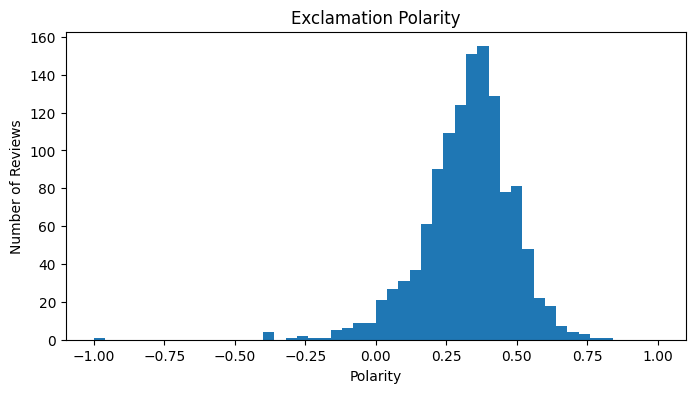

In [54]:
df['exclamation_polarity'] = df[df['exclamation'] == 1]['reviews_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
 
ax.hist(df.exclamation_polarity, bins=50, range=(-1, 1))
plt.title('Exclamation Polarity')
plt.xlabel('Polarity')
plt.ylabel('Number of Reviews')
plt.show()

In [55]:
df = df.drop(['exclamation_polarity'], axis=1)

To be on the safe side (and to save me a ton of code, like, "for x in [polarity column] where reviews_rating == 5(just in case): write a ton of code here"), I thought I would better check the average polarity scores for the reviews rating!  There will be low-scoring reviews with decent polarity here and there but as long as the averages look good then I can say with a degree of certainty that my NLP analysis is as good as it would be if I were looking at review rating scores.

In [56]:
for x in range(5, 0, -1):
    print(f"The average polarity for {x} star ratings is: {df[df.reviews_rating == x].polarity.mean()}. ") # I could be a CodeWars 8Kyu master

The average polarity for 5 star ratings is: 0.363894085424759. 
The average polarity for 4 star ratings is: 0.29316274592462765. 
The average polarity for 3 star ratings is: 0.19439861225403984. 
The average polarity for 2 star ratings is: 0.09157512718647885. 
The average polarity for 1 star ratings is: 0.015101448984933126. 


### Hotels by polarity score. 

1: Positive.

• The top 20 hotels with the highest average polarity score shows Roseberry's Inn holding the most positives on average, warranted, as it looks like a lovely place to stay.  

• Gordon beach Inn sits at second-most positive on average, then the Lodge at Lolo Hot Springs:

In [57]:
hotel_high_polarity = df.groupby('name')['polarity'].mean()
hotel_high_polarity = hotel_high_polarity.sort_values(ascending=False)
hotel_high_polarity = hotel_high_polarity.head(20)

fig = px.bar(hotel_high_polarity, x=hotel_high_polarity.index, y=hotel_high_polarity.values, color=hotel_high_polarity.values,
                labels={'x':'Hotel Name', 'y':'Average Polarity', 'color':'Average Polarity'},
                title='The 20 most common hotels with the Highest Average Polarity')
fig.show()

2: Negative. 

• The Knights Inn holds the two highest values for negative polarity.

• The Super 8 Dubois comes in at an equally, but only mildly disappointing third place. 

In [58]:
hotel_low_polarity = df.groupby('name')['polarity'].mean()
hotel_low_polarity = hotel_low_polarity.sort_values(ascending=True)
hotel_low_polarity = hotel_low_polarity.head(20)

fig = px.bar(hotel_low_polarity, x=hotel_low_polarity.index, y=hotel_low_polarity.values, color=hotel_low_polarity.values,
                labels={'x':'Hotel Name', 'y':'Average Polarity', 'color':'Average Polarity'},
                title='The 20 most common hotels with the Lowest Average Polarity')
fig.show()

### Pos / neg polarity distribution by province. 

It seems like the negative sentiment isn't too far out of line in most areas, growing in conjunction with the amount of positive reviews / reviewer counts with the odd outlier here and there, such as Louisiana (looking like a good state to travel to with only 2% of its total polarity scoring as negative).  

Besides NJ (with 18 negative and 32 positive), there doesn't appear to be any surprises as far as negative polarity goes.

In [59]:
fig = px.sunburst(df, path=['province', 'analysis'], 
                    color_continuous_scale='RdBu',
                    title='Polarity analysis of Hotel Reviews by Province')
fig.update_layout(
    autosize=False,
    width=600,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    )),
fig.show()

### Polarity distribution by day. 

1: Positive. 

The distribution of positive reviews per day is exactly the same as the overall reviews left per day, no surprises considering the majority of reviews are positive.  

Again, Monday is the most common day for leaving reviews, then it's Tuesday, Wednesday, Sunday, Thursday, Friday and Saturday in that order.

In [60]:
positive_polarity_day = df[df['polarity'] > 0]
positive_polarity_day = positive_polarity_day.groupby('reviews_day').count()
positive_polarity_day = positive_polarity_day.reset_index()
fig = px.bar(positive_polarity_day, x='reviews_day', y='polarity', title='Positive Polarity by day')
fig.update_traces(marker_color='lightgreen')
fig.update_layout(xaxis={'categoryorder':'total descending'}, height=400)
fig.show()

2: Negative.

A slight difference in the negative reviews per day here, Tuesday and Monday have swapped places, Wednesday is still the third-most common day for negative as it is for positive, but now Saturday is the fourth-most common day which is quite surprising.  

Friday and Thursday have swapped places for the 5th and 6th most common days, and Sunday is the least common day for negative reviews.

In [61]:
negative_polarity_day = df[df['polarity'] < 0]
negative_polarity_day = negative_polarity_day.groupby('reviews_day').count() 
negative_polarity_day = negative_polarity_day.reset_index()
fig = px.bar(negative_polarity_day, x='reviews_day', y='polarity', title='Negative Polarity by day')
fig.update_traces(marker_color='lightgreen')
fig.update_layout(xaxis={'categoryorder':'total descending'}, height=400)
fig.show()

### Polarity distribution by month. 

1: Positive. 

Polarity by month tells a similar story to the best review scores (naturally), with July, May and August being the top three most positive review months.

In [62]:
positive_polarity_month = df[df['polarity'] > 0]
positive_polarity_month = positive_polarity_month.groupby('reviews_month').count()
positive_polarity_month = positive_polarity_month.reset_index()

fig = px.histogram(positive_polarity_month, x='reviews_month', y='polarity', title='Positive Polarity by Month')
fig.update_traces(marker_color='lightblue')
fig.update_layout(xaxis={'categoryorder':'total descending'}, height=400)
fig.show()


2: Negative. 

But, the negative polarity by month chart sees August, June and September as the most common months for negative reviews.  As these are counts as opposed to averages, August and July will score highly for both positive and negative polarity due to the amount of holidaymakers in those months.

In [63]:
negative_polarity_month = df[df['polarity'] < 0]
negative_polarity_month = negative_polarity_month.groupby('reviews_month').count()
negative_polarity_month = negative_polarity_month.reset_index()

fig = px.bar(negative_polarity_month, x='reviews_month', y='polarity', title='Negative Polarity by Month')
fig.update_traces(marker_color='lightblue')
fig.update_layout(xaxis={'categoryorder':'total descending'}, height=400)
fig.show()

### Polarity distribution by year. 

1: Positive.

The positive and negative polarities by year don't see too many differences besides 2015 where the negative polarity jumps up slightly in accordance to the positive polarity.  A record number of Americans travelled abroad in 2015 so this maybe had some impact.  2005's negative polarity is also worthy of note, possibly due to Hurricane Katrina, oil price surges and the like.

In [64]:
positive_polarity_year = df[df['polarity'] > 0]
positive_polarity_year = positive_polarity_year.groupby('reviews_year').count()
positive_polarity_year = positive_polarity_year.reset_index()
fig = px.bar(positive_polarity_year, x='reviews_year', y='polarity', title='Positive Polarity by Year')
fig.update_traces(marker_color='lightgreen')
fig.update_layout(xaxis={'categoryorder':'total descending'}, height=400)
fig.show()

2: Negative. 

In [65]:
negative_polarity_year = df[df['polarity'] < 0]
negative_polarity_year = negative_polarity_year.groupby('reviews_year').count()
negative_polarity_year = negative_polarity_year.reset_index()
fig = px.bar(negative_polarity_year, x='reviews_year', y='polarity', title='Negative Polarity by Year')
fig.update_traces(marker_color='lightgreen')
fig.update_layout(xaxis={'categoryorder':'total descending'}, height=400)
fig.show()

### Top provinces for negative sentiment in 2015.

Looking at the top provinces for negative sentiment 2015 shows Cali holding the number one spot, in accordance with its level of tourism, so let's check some hotel names. 

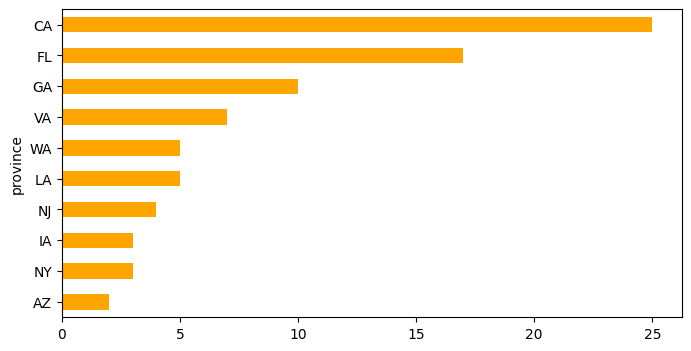

In [66]:
neg_year_province = df[(df['analysis'] == 'Negative') & (df['reviews_year'] == 2015)]['province']
neg_year_province.value_counts().head(10).plot(kind='barh', figsize=(8, 4), color='orange').invert_yaxis()

There are a few hotels causing that spike in 2015's negativity, primarily the Best Western Seven Seas.  2015 saw some very hot / dry weather in Cali along with some droughts so I will give the hotel some credit and suppose the words 'critters', 'centipedes', 'spiders', 'crawling' etc. in the data for the Seven Seas for this year are a result of that, with the critters seeking refuge from the heat within the confines of the hotel.  I checked the hotel online and it mostly looks like a case of a great hotel being let-down by unreliable management, which is a shame for what could be an amazing place.  Beautiful surroundings, perfectly situated for the local attractions, a nice building, the decor isn't bad considering almost every facet of the hotel has been taken for granted.  Neglect is still the primary reason it's being plagued by bad reviews in 2023, a few of the reviews I have seen still mention the same odor in some of the rooms that was mentioned years ago.  Granted, the current-era odour could be a different odour to the odour of yore, but the presence of any untreated 'stank' usually reflects a certain degree of neglect either way.  

This is a common issue with hotels in many popular tourism destinations I've worked in over the years; the hotelier won't have a hospitality background but will be aware that the repeat custom will come rolling in irrespective of negative reviews due to the location of the hotel and the reasonable room pricing, resulting in some good financial returns for next to no investment / an acceptable reputation risk for the business owner which the location and affordability factors outweigh.  Proved again here, by the lack of staff training in the reviews.  Considering the location, if this hotel owner spent [x] amount on reviving the hotel, they could easily quadruple that investment in a few years' time once they'd (justifiably) adjusted the room prices to reflect the refurb cost, but as it stands, the customers will keep booking and it's those customers who suffer.  Quite a pity in all honesty, the main product the customer pays for is peace of mind, and customers who purchase hotel stays should be expecting a bare minimum quality of 'comfortable' at the very least, no matter what the base price is. 

One quick edit to add my favourite review of this hotel: 

"A FREAKING BEE WAS CHASING MY SON AROUND THE ROOM..."

Not particularly the fault of the hotelier in all fairness... 

In [67]:
df[(df.reviews_year == 2015) & (df.province == 'CA') & (df.analysis == 'Negative')].name.value_counts().head(10)

name
Best Western Seven Seas                   4
Hampton Inn San Diego Del Mar             3
Comfort Inn                               2
Quality Suites San Diego SeaWorld Area    2
Hampton Inn San Diego/Mission Valley      1
Civic Center Inn                          1
Greenwich Inn                             1
San Francisco International Hostel        1
Minna Hotel                               1
Best Western Cabrillo Garden Inn          1
Name: count, dtype: int64

In [68]:
df[(df.reviews_year == 2015) & (df.province == 'CA') & (df.analysis == 'Negative')].reviews_text.values[:10]

array(['ac unit window blows air directly bed like cold sleep order ac sleep blows wind chill bed move yhe room chair front ac block air flow',
       'guess dont care little critters creep around room informed front desk said hum usually rooms sprayed found two centipedes spiders crawling around',
       'checked around pm room air conditioner turned room odor ref unplugged figure socket cant dry hair keep ref plugged time microwave room convenient place use lobby',
       'bad hotel circle slightly dated clean restaurant isnt terrible either guess hot tub open hours day pretty grounds slightly inconvenient location however absolutely must car',
       'disappointed made reservation lower level room time checked forced take stairwell second floor specifically asked lower level mother bad hips hard time climbing stairs second floor would fine elevator least resulted us hauling luggage wouldnt fall displeased start added insult injury extremely rude nature check receptionist',
       't

### Analysing hotel-specific ngrams. 

(removed for brevity's sake).  

Following some ngram investigation: 

### Polarity for the keyword "weather".

In [69]:
df['weather'] = df['reviews_text'].apply(lambda x: 1 if 'weather' in x else 0)

It looks like North Dakota, Oklahoma and Massachusetts score the highest in the negative weather reviews.  Seeing as I'm from a tiny northern town in England that nobody has heard of & have never been to ND, I will look into this online and knock-up a word cloud for further investigation.

First, a bar chart visualising the negative polarity rate where the word 'weather' was mentioned in the reviews (orange = not great):

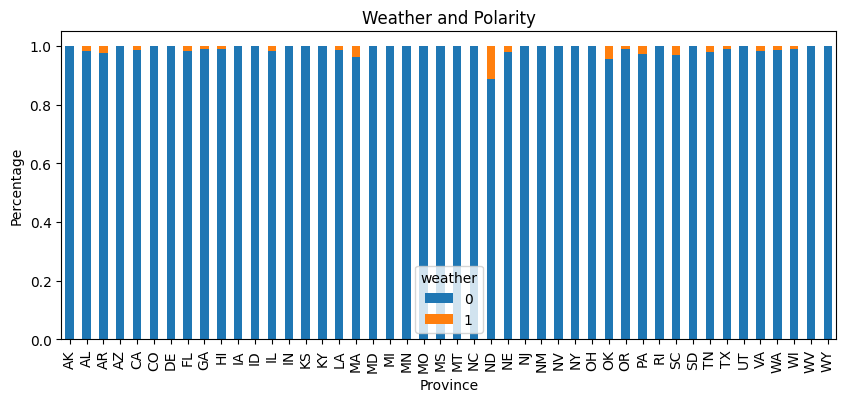

In [70]:
def plot_weather_polarity(df):
    df = df.groupby(['weather', 'polarity', 'province']).size().reset_index(name='counts')
    df = df.groupby(['weather', 'province']).agg({'counts': 'sum'}).reset_index()
    df['counts'] = df['counts'].astype(float)
    df = df.pivot(index='province', columns='weather', values='counts')
    df = df.div(df.sum(axis=1), axis=0)
    df.plot.bar(stacked=True, figsize=(10, 4))
    plt.title('Weather and Polarity')
    plt.xlabel('Province')
    plt.ylabel('Percentage')
    plt.show()


weather_polarity = plot_weather_polarity(df)

In [71]:
text_by_weather_neg = pd.DataFrame(df[(df['weather'] == 1) & (df['polarity'] < 0)]['reviews_text'].dropna())

The general rule of thumb is to assume that not all of the text in the reviews where negative sentiment regarding the weather will purely be because of the weather.  Miserable weather makes people miserable and this will influence their review polarity, although I won't accept these results as completely conclusive based on the fact that so much can go wrong in hotels, leaving many things besides the weather to complain about.

Although, the main province for negative polarity where the weather is concerned is North Dakota, a state that  does have some pretty extreme conditions, humid summers, pretty terrible winters and lots of rain in-between.  Some of the words in the word cloud back that up, with 'mildew', 'winter', 'water', 'lung' present.  On the other end of the spectrum we see, 'air',  'conditioner', 'hot', etc., amid other words such as 'stranded' and 'rude'.  So, a mixture of things, but primarily bad staff, rooms and food.  Whether (no pun intended) the hot or cold conditions were the sole deciding factor behind the negative reviews is then up for debate considering all of the other unrelated words in the word cloud, but I don't think they helped matters.

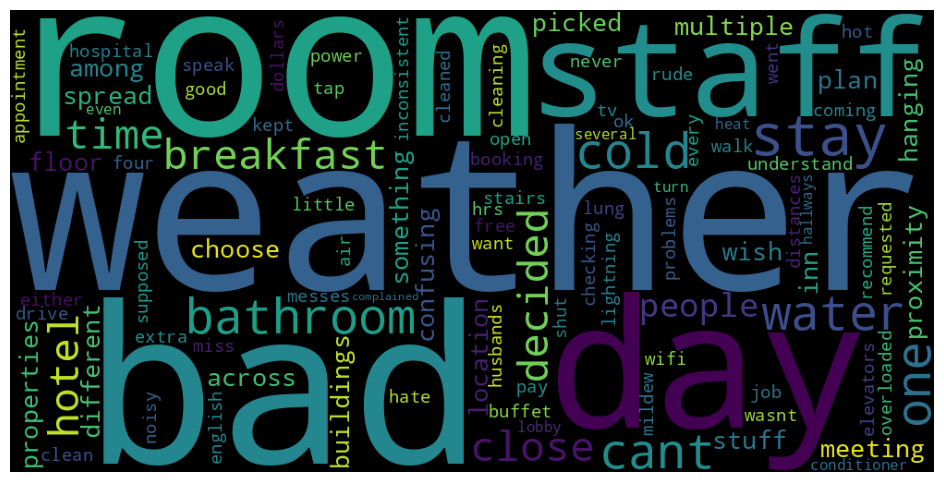

In [72]:
wordcloud = WordCloud(width=1000, height=500).generate(' '.join(text_by_weather_neg['reviews_text']))
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Negative reviews containing the word "weather" by month. 

The majority of the negative reviews where the weather is related were written in February, March, October and December.  The next outlier month that isn't a cold month is July.   

Personally, I wouldn't like to go to ND  - or anywhere for that matter - in Feb or March, and October is usually monsoon season.  Each to their own.

In [73]:
weather_by_month = df.groupby('reviews_month')['weather'].sum()
weather_by_month = weather_by_month.sort_values(ascending=False)

fig = px.bar(weather_by_month, x=weather_by_month.index, y=weather_by_month.values, color=weather_by_month.values,  color_continuous_scale='YlOrRd')
fig.update_layout(title='Negative reviews including the weather by month', xaxis_title='Month', yaxis_title='Weather', height=400)
fig.show()


### Polarity for the keyword "beds".

In [74]:
df['bed'] = df['reviews_text'].apply(lambda x: 1 if 'bed' in x else 0)

It appears that only three provinces are responsible for 100% positive polarity as far as the beds go, and they're: 'RI' (Rhode island), 'ND' (North Dakota) and 'DE' (Delaware).  Nice to see the beds in ND making-up for the shabby weather.

The worst provinces for negative bed reviews are Massachusetts, New Jersey and Nebraska.

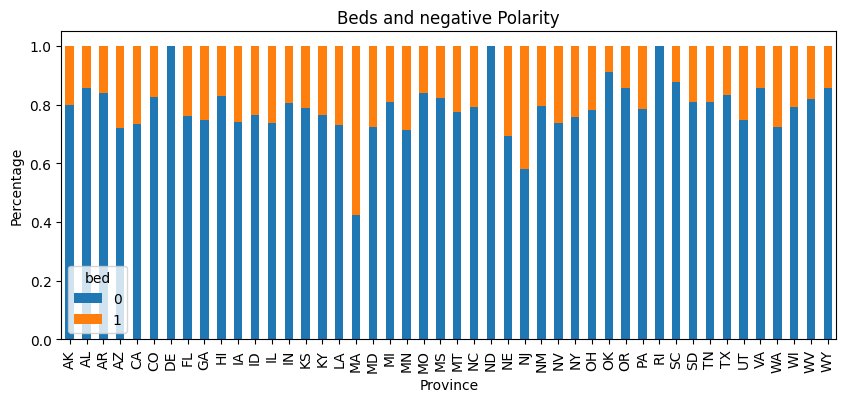

In [75]:
def plot_bed_polarity(df):
    df = df.groupby(['bed', 'polarity', 'province']).size().reset_index(name='counts')
    df = df.groupby(['bed', 'province']).agg({'counts': 'sum'}).reset_index()
    df['counts'] = df['counts'].astype(float)
    df = df.pivot(index='province', columns='bed', values='counts')
    df = df.div(df.sum(axis=1), axis=0)
    df.plot.bar(stacked=True, figsize=(10, 4))
    plt.title('Beds and negative Polarity')
    plt.xlabel('Province')
    plt.ylabel('Percentage')
    plt.show()


bed_polarity = plot_bed_polarity(df)

In [76]:
bed_negative_polarity = pd.DataFrame(df[(df['bed'] == 1) & (df['polarity'] < 0)]['name'].dropna())

### Top hotels for negative polarity mentioning the word "bed".

A histogram of the negative 'bed' polarity by hotel name clearly shows the Days Inn by Windham, the Annex at the Chelsea, the Econo Lodge and the Best Western Orlando East holding the largest share of negative bed reviews.

In [77]:
fig = px.histogram(bed_negative_polarity, x="name", title="Hotels with negative polarity where 'bed' is mentioned")
fig.update_xaxes(categoryorder="total descending")
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                    marker_line_width=1.5, opacity=0.6)
fig.update_layout(height=500)
fig.show()

### Polarity for the keyword "cheap". 

In [78]:
df['cheap'] = df['reviews_text'].apply(lambda x: 1 if 'cheap' in x else 0)

Here we see Delaware, New Joisey and Massachusetts take the three top spots for 'cheap' mentions  in the negative reviews.

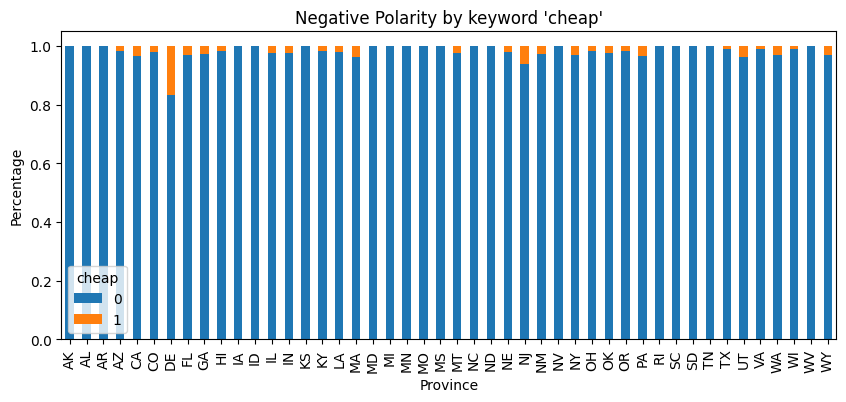

In [79]:
def plot_cheap_polarity(df):
    df = df.groupby(['cheap', 'polarity', 'province']).size().reset_index(name='counts')
    df = df.groupby(['cheap', 'province']).agg({'counts': 'sum'}).reset_index()
    df['counts'] = df['counts'].astype(float)
    df = df.pivot(index='province', columns='cheap', values='counts')
    df = df.div(df.sum(axis=1), axis=0)
    df.plot.bar(stacked=True, figsize=(10, 4))
    plt.title("Negative Polarity by keyword 'cheap'")
    plt.xlabel('Province')
    plt.ylabel('Percentage')
    plt.show()


cheap_polarity = plot_cheap_polarity(df)

In [80]:
cheap_negative_polarity = pd.DataFrame(df[(df['cheap'] == 1) & (df['polarity'] < 0)]['name'].dropna())

With the Baymont by Windham Florida Mall and the Best Western Seven Seas each holding two counts.

In [81]:
fig = px.histogram(cheap_negative_polarity, x="name", title="Hotels with negative polarity where 'cheap' is mentioned")
fig.update_xaxes(categoryorder="total descending")
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                    marker_line_width=1.5, opacity=0.6)
fig.update_layout(height=500)
fig.show()

### Moving on...  The top 10 provinces by polarity. 

In [82]:
def province_by_positive_review(df):
    df = df[df['reviews_rating'] == 5]
    df = df.groupby(['province'])['reviews_rating'].count().reset_index()
    df = df.sort_values(by=['reviews_rating'], ascending=False)
    df = df.rename(columns={'reviews_rating': 'positive_reviews'})
    df = df.reset_index(drop=True)
    return df[:10]
    

def province_by_negative_review(df):
    df = df[df['reviews_rating'] < 5]
    df = df.groupby(['province'])['reviews_rating'].count().reset_index()
    df = df.sort_values(by=['reviews_rating'], ascending=False)
    df = df.rename(columns={'reviews_rating': 'negative_reviews'})
    df = df.reset_index(drop=True)
    return df[:10]

### The top (or bottom, depending on how you look at it -.-) 10 provinces for negative polarity. 

These numbers are in keeping with the total amount of holidaymakers but we may see the odd outlier here.

Here we see GA positioned slightly higher in the negative review table as it was in the positive review table.  HI pops up for the negative reviews but is nowhere to be seen in the positive review table.

In [83]:
province_by_negative_review(df)

,province,negative_reviews
0,CA,1546
1,FL,640
2,GA,500
3,LA,367
4,WA,361
5,TX,237
6,IL,228
7,HI,188
8,PA,130
9,NY,64


Let's have a look to see what's going on in Georgia!

In [84]:
ga_negative_polarity = pd.DataFrame(df[(df['province'] == 'GA') & (df['polarity'] < 0)]['reviews_text'].dropna())

The standout, but not outstanding words here are 'Disappointed', 'Run down', 'mattresses terrible', 'pool closed', 'nastiness' etc..  I'll grab some hotel  names and see what pops up in a word cloud once I've narrowed it down to specific hotels:

In [85]:
ga_negative_polarity.head(10)

,reviews_text
926,read reviews place realize major shortcomings ...
1652,stayed feb horrible place paid room right down...
2269,hotel rundown disappointed mattresses terrible...
2441,room great size updated nice showertub dirty p...
2452,town training booked room location hotels pric...
2457,normally travel quite bit meeting attending de...
2475,hi change two rooms due dust nastiness rooms t...
2476,disappointed breakfast food good room cleaned ...
2477,hotel stay ruined pool closed nd day due child...
2489,unhappy service room one nite go front desk sh...


Grabbing the hotel names in GA where the polarity is negative, the Wingate tops the list followed swiftly by the Residence Inn /Peachtree at 17th.

In [86]:
negative_ga_hotel_names = df[(df.province == 'GA') & (df.polarity < 0)].groupby('name').polarity.count().sort_values(ascending=False)
negative_ga_hotel_names.head(10)

name
Wingate By Wyndham Atlanta Galleria Center                     8
Residence Inn Atlanta Midtown/Peachtree at 17th                5
The Ritz-Carlton, Atlanta                                      4
Quality Suites Buckhead Village                                4
Hampton Inn Atlanta-Perimeter Center                           3
Fairfield Inn & Suites by Marriott Atlanta Buckhead            2
Extended Stay America - Atlanta - Perimeter - Hammond Drive    2
Motel 6 Atlanta Downtown                                       2
Motel 6-perry                                                  2
Hampton Inn Atlanta - Cumberland Mall / NW                     2
Name: polarity, dtype: int64

### Wingate reviews.

Grabbing the Wingate reviews now.

In [87]:
wingate_neg_reviews = pd.DataFrame(df[(df.name == 'Wingate By Wyndham Atlanta Galleria Center') & (df.polarity < 0)]['reviews_text'].dropna())
wingate_neg_reviews

,reviews_text
2441,room great size updated nice showertub dirty p...
2452,town training booked room location hotels pric...
2457,normally travel quite bit meeting attending de...
2475,hi change two rooms due dust nastiness rooms t...
2476,disappointed breakfast food good room cleaned ...
2477,hotel stay ruined pool closed nd day due child...
2489,unhappy service room one nite go front desk sh...
2512,third year stayed particular hotel attending e...


### Wingate word cloud.

Some words in the negative polarity word cloud worthy of note for the Wingate are, 'pool', 'shocked', 'management', 'staff', 'failed', 'respiratory problems', 'housekeeping', 'smoke', 'bugs', 'incident', 'nasty' and 'dirty'.  

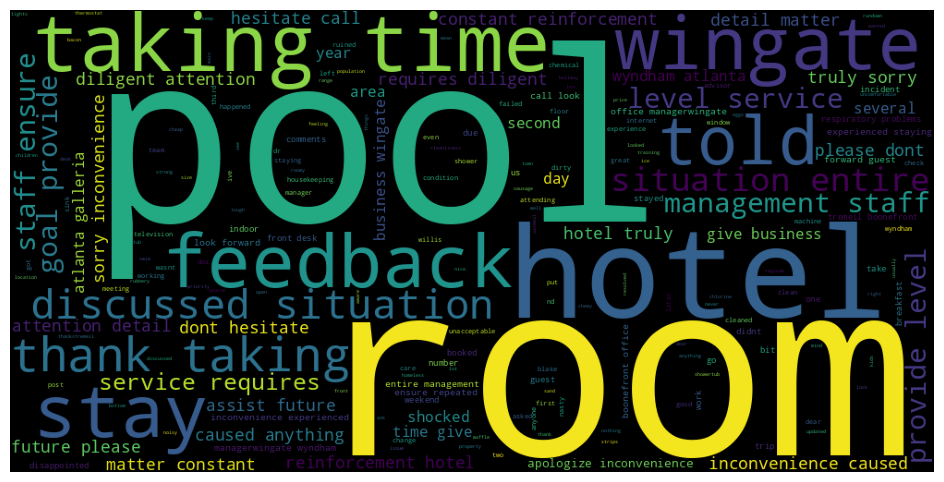

In [88]:
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(wingate_neg_reviews['reviews_text']))
plt.figure(figsize=(15,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### The Peachtree at 17th reviews.

In [89]:
peachtree_neg_reviews = pd.DataFrame(df[(df.name == 'Residence Inn Atlanta Midtown/Peachtree at 17th') & (df.polarity < 0)]['reviews_text'].dropna())
peachtree_neg_reviews

,reviews_text
8663,convenient location midtown however elevators ...
8664,car rider green cards dismissalplease continue...
8665,c room broken toilets refrigerator ran night l...
8669,place unsafe cameras dont work atleast werent ...
8676,stayed business trip basic setup standard resi...


For the secondmost common hotel in GA with negative polarity, the Residence Inn Atlanta Midtown/Peachtree at 17th, we see, 'service', 'disappointing', 'noises', 'broken', 'dirty', 'filthy', 'problems-terrible', 'elevators' (although possibly not associated with negativity, but we do also see 'maintenance'), 'slow', 'unimpressed' and 'shock'.

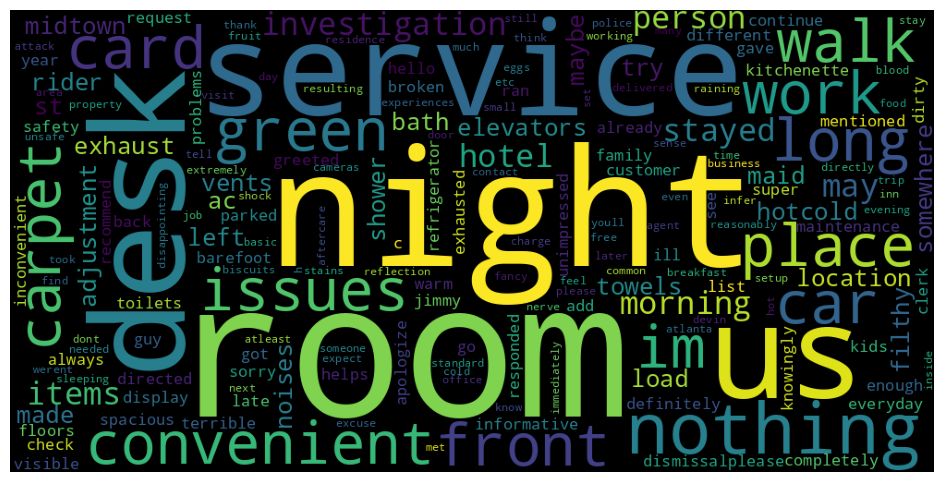

In [90]:
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(peachtree_neg_reviews['reviews_text']))
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

So, as a business analysis it isn't too difficult to continue on in this vein and uproot hotel-specific issues in a bid to bring further attention to them, but I will stop there because the curious hacker in me could happily go on forever.

Now, let's look at some review polarities by username.  First I will create a new dataframe containing the review usernames, polarity scores and a count of total reviews left by each user.

In [91]:
df_reviews_user = df[['reviews_username', 'polarity']]
df_reviews_user = df_reviews_user.groupby('reviews_username').agg({'polarity': 'sum'})
df_reviews_user['reviews_count'] = df['reviews_username'].value_counts()
df_reviews_user.head()

,polarity,reviews_count
reviews_username,,
#1Cubsfan,0.186905,1
007traveler64,0.316290,1
0413beanie,-0.100000,1
059DebDeb056,0.324722,1
09LCM,-0.066071,2


### Polarity by username. 

Sorting the username values by max positive polarity.

In [92]:
most_positive_users = df_reviews_user.sort_values(by='polarity', ascending=False).head(10)
most_positive_users

,polarity,reviews_count
reviews_username,,
John C,2.572123,7
Ann M,2.378939,5
Linda C,2.310623,6
Michael B,2.173802,6
Michael M,2.085595,7
Angela H,1.892430,5
Lisa H,1.797517,5
Robert S,1.780498,5
Paul G,1.768238,4


And sorting them again by review count per user.

In [93]:
most_active_users = df_reviews_user.sort_values(by='reviews_count', ascending=False).head(10)
most_active_users

,polarity,reviews_count
reviews_username,,
Michael M,2.085595,7
David W,1.521671,7
John C,2.572123,7
John M,1.743085,6
Michael B,2.173802,6
Linda C,2.310623,6
Robert S,1.780498,5
Mark H,1.735736,5
Laura M,0.967690,5


### The users responsible for the most negative reviews.

Just in case they're fake accounts.  

You're welcome. 

In [94]:
most_negative_users = df_reviews_user.sort_values(by='polarity', ascending=True).head(10)
most_negative_users

,polarity,reviews_count
reviews_username,,
Wesley C,-0.867101,2
Androidfan123,-0.700000,1
anonymous_person96,-0.633333,2
Richard Y,-0.591667,1
kathleenbC2311PB,-0.568000,1
magjonmar,-0.550000,1
listen69,-0.550000,1
jonathan_becerril112,-0.540000,1
Nalistar,-0.533333,1


### The least active users (minimum review count by username).

In [95]:
least_active_users = df_reviews_user.sort_values(by='reviews_count', ascending=True).head(10)
least_active_users

,polarity,reviews_count
reviews_username,,
ahmedmH6570NC,0.325000,1
advantagebill2,0.152381,1
aeoknowsnada,0.358730,1
aestewart10,0.268750,1
afrye332663,-0.079167,1
ag3t293,0.055556,1
agentmc1,0.483631,1
agschaser,0.138889,1
ahappygirl,0.181752,1


### The distribution of hotel reviews left by the top positive reviewers.

(Hover on the bars for extra information if you're still awake at this point)

In [96]:
hotels_by_username = df[df['reviews_username'].isin(['Michael M', 'David W', 'John C', 'John M', 'Michael B', 'Linda C', 'Michael M', 'Angela H', 'Lisa H', 'Mark H', 'Eric B', 'Robert S'])]
fig = px.bar(hotels_by_username, x='name', y='reviews_rating', color='reviews_username', title='The most positive reviews per hotel by Username')
fig.update_layout(height=700)
fig.show()

### And for the fun of it, checking out some frequently occurring words.

Removing some frequent chaff words.

In [97]:
freq = ['hotel', 'room', 'rooms','yearold',  'stay', 'staff',  'us', 'resort', 'nice', 'great', 'one', 'thank', 'stayed', 'night', 'the', 'and', 'to', 'a', 'was', 'san', 'nights', 'day', 'good', 'days', 'time', 'times', 'trip', 'trips', 'philadelphia', 'week', 'chicago', 'seattle', 'boston', 'atlanta', 'weekend', 'weekends', 'month', 'months', 'year', 'years', 'place', 'places', 'location', 'locations', 'experience', 'experiences', 'thing', 'things']
df['reviews_text_new'] = df.reviews_text.apply(lambda x: " ".join(x for x in x.split() if x not in freq))

Grouping the most common words in df.reviews_text by province, including a new column containing their frequencies.

In [98]:
common_keywords_by_province = df.groupby('province')['reviews_text_new'].apply(lambda x: pd.Series(x.str.split(expand=True).stack().value_counts().head(5))).reset_index()

In [99]:
common_keywords_by_province.sort_values(by='reviews_text_new', ascending=False).head(10)

,province,level_1,reviews_text_new
20,CA,clean,1262
21,CA,breakfast,1189
22,CA,would,1168
23,CA,best,882
24,CA,back,846
35,FL,breakfast,640
36,FL,clean,589
80,LA,french,567
81,LA,new,530
37,FL,would,508


Sorting the singlemost common word in df.reviews_text by province.

In [100]:
most_common_word = common_keywords_by_province.groupby('province')['level_1'].agg(lambda x: x.value_counts().index[0])
most_common_word = most_common_word.reset_index()
most_common_word.columns = ['province', 'most_common_word']
most_common_word.head()

,province,most_common_word
0,AK,downtown
1,AL,clean
2,AR,clean
3,AZ,breakfast
4,CA,clean


### Hospitality companies in operation.

In a bid to see which hotel companies are the leaders, I will parse the first two words (excluding the word 'the') from the features in df.name, then I will merge / count them up, drop duplicates and visualise them.

In [101]:
df.name = df.name.str.replace('-', ' ')

In [102]:
df['company_name'] = df['name'].str.split().str[:3].str.join(' ')

In [103]:
df['company_name'] = df['company_name'].apply(lambda x: x[4:] if x[:3] == 'The' else x)

For a 30 second strategy, this looks almost passable-ish.

I will remove some words such as 'san' from the hotel title but I won't go too far with it.  If I were to be doing this as per a paid employee with time to spare as opposed to off my own back for fun, I would remove any county / state names or franchise-specific words from the titles (such as 'san', 'garden' etc.) and narrow it down a lot more.  So this method isn't completely fair on some brands owning different styled hotels in different towns, but if they are such a large chain then they will appear here anyway.  I think that if 'Hilton Garden' is at number 3 in the top 20 hotel brands then the other hotels with 'Hilton' as the precursor will only serve to keep that chain in the top three hotel brands in this list regardless.  Additionally, single hotels not associated with a brand such as Hotel Emma will exist in this part of the data for obvious reasons.  

Had this been a professional project I would filter these out by using the company names in the URLs at the beginning of the EDA.  

In [104]:
df['company_count'] = df['company_name'].apply(lambda x: len(x))

Removing the words 'san', 'by', as well as commas and ampersands from the end of each string in company_name.

In [105]:
items_to_remove = ['san', 'by', ',', '&']
df['company_name'] = df['company_name'].apply(lambda x: ' '.join([word for word in x.split() if word not in (items_to_remove)]))

### The 20 most commonly rated hotel companies.

Best Western, Hilton Garden and Hampton Inn are the top three most rated brands. 

In [106]:
top_20_companies = df.company_name.value_counts()
top_20_companies = pd.DataFrame(top_20_companies)
top_20_companies = top_20_companies.reset_index()
top_20_companies.columns = ['company_name', 'company_count']
top_20_companies = top_20_companies.head(20)

In [107]:
fig = px.bar(top_20_companies, x='company_name', y='company_count', title='Top 20 hotel brands / companies in the dataset by the amount of times reviewed', height=400)
fig.show()

Returning a table consisting of the amount of times a hotel brand appears in each exact geolocation.  As far as i'm concerned the most logical strategy would be to combine the latitude & longitude coordinates and link them to a company name in the next column, this way I can also count how many times the company name or hotel at those coordinates comes up and add those counts to another column called 'review_counts' (or something similar).

First, combining both coordinate features (latitude and longitude) into one single tuple, in a new column named 'lat_long'.

In [108]:
df['lat_long'] = df[['latitude', 'longitude']].apply(tuple, axis=1)

In [109]:
pd.DataFrame(df.lat_long).head()

,lat_long
0,"(34.44178, -119.81979)"
1,"(36.55722, -121.92194)"
2,"(36.55722, -121.92194)"
3,"(36.55722, -121.92194)"
4,"(36.55722, -121.92194)"


Creating a new df called 'geo_groups' consisting of those geographical coordinate tuples along with the corresponding company name, a count of how many occurrences of the company name appears per unique lat_long feature (hotel_count), the province column, and a review count column (how many instances of each tuple exists per company_name feature).

In [110]:
geo_groups = df.groupby(['lat_long', 'company_name', 'province']).size().reset_index(name='review_count')

In [111]:
geo_groups['hotel_count'] = geo_groups.groupby(['company_name', 'province'])['lat_long'].transform('nunique')

In [112]:
geo_groups.head()

,lat_long,company_name,province,review_count,hotel_count
0,"(19.438604, -155.88747)",Pomaika'i Lucky Farm,HI,1,1
1,"(20.705, -156.4451)",Days Inn Maui,HI,1,1
2,"(20.917433, -156.67715)",Ka'anapali Beach Club,HI,2,1
3,"(20.91832, -156.69547)",Kaanapali Alii,HI,1,1
4,"(20.9418, -156.6907)",Westin Nanea,HI,52,1


The features in hotel_count (max, descending) per province in geo_groups.

In [113]:
hotel_max = geo_groups.sort_values(by=['hotel_count'], ascending=False).groupby('province').head(1)
hotel_max = hotel_max[['province', 'company_name', 'hotel_count']]
hotel_max = hotel_max.rename(columns={'company_name': 'company_name_max'})
hotel_max = hotel_max.reset_index(drop=True)
hotel_max.head(10)

,province,company_name_max,hotel_count
0,CA,Best Western Plus,14
1,TX,Best Western Plus,5
2,AL,Quality Inn,5
3,FL,Hilton Garden Inn,4
4,OR,Best Western Plus,4
5,NY,Best Western Plus,4
6,TN,Hampton Inn Suites,3
7,OK,Best Western Plus,3
8,GA,Motel 6 Atlanta,3
9,PA,Best Western Plus,3


Best Western seems to have the greatest land share in a couple of provinces so I'll have a quick look into how many appear here exactly.  Best Western have 138 hotels in Cali alone as of 2023 but they won't all be in the dataset.  However, I'm willing to eat my hat if they don't have the majority count here anyway.

In [114]:
count_best_western = 0

for i in geo_groups.company_name:
    if i.split()[0] == 'Best' and i.split()[1] == 'Western':
        count_best_western += 1

print(f'There are {count_best_western} Best Westerns in the geo_groups dataset. ')   

There are 142 Best Westerns in the geo_groups dataset. 


### Distance travelled per reviewer (data not currently present).

Ok so this one hurt a little.  I wanted to figure out the coordinates for the reviews_usercity features to get a sum-total distance travelled to the hotel's location for each username.  I tried a few APIs but they all had limits and / or timed-out due to the data download limit, so because I didn't wish to split the dataframe in half and max the API out over a few days, I decided to do it manually.  

What I did was:

Scraped an American government website that was full of latitude and longitude coordinates for a bunch of cities in America.

Created a copy of the original dataframe and named it "df_city".

Placed df.city's values in a list (list_1) and placed df_city.reviews_usercity's values in a second list (list_2).  There weren't many matching cities between the two though.

So I dropped from list_2 what wasn't in list_1 to get a complete list with no missing values.

Then combined the latitude and longitude columns into one column called 'city_coordinates' (as per df.lat_long above) in the df_city dataframe.

After that, I created a new df column 'df['reviews_usercity_coords']' which I filled with the values in df_city.city_coordinates where df.reviews_username.and city_df.reviews_username were the same values using this absolute unit of a one-liner:

In [115]:
# df['reviews_usercity_coords'] = df.apply(lambda x: df_city[df_city.reviews_username == x.reviews_username].city_coordinates.values[0] if x.reviews_username in df_city.reviews_username.values else np.nan, axis=1).

Now time to split the coordinates in usercity_loc_df into usercity_loc_df['user_latitude'] and usercity_loc_df['user_longitude'] columns and create another column called df['reviewer_distance_travelled'] for the values in latitude and longitude that are present for a df.reviews_username using h3, sorting and users by travel distance.

In [116]:
# usercity_df = pd.read_csv(r"")

In [117]:
# fig = px.bar(usercity_df.sort_values(by='reviewer_distance_travelled', ascending=False).head(50),
#                 x='reviews_username', y='reviewer_distance_travelled', color='reviews_username',
#                 title='Top 50 users with the longest travel distances to hotels')
# fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
#                     marker_line_width=1.5, opacity=0.6)
# fig.show()

### DBSCAN for business recommendations and optimisation. 

In [118]:
data = pd.read_csv('/work/Datafiniti_Hotel_Reviews_Jun19.csv')

geo_data = data[['latitude', 'longitude']].dropna()

eps = 0.1  
min_samples = 5  

cluster_model = DBSCAN(eps=eps, min_samples=min_samples, metric='haversine').fit(geo_data)
geo_data['cluster'] = cluster_model.labels_

data['cluster'] = geo_data['cluster']
data.head()

,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sourceURLs,websites,cluster
0,AWE2FvX5RxPSIh2RscTK,2018-01-18T18:43:12Z,2019-05-20T23:55:47Z,5620 Calle Real,"Hotels,Hotels and motels,Hotel and motel mgmt....",Accommodation & Food Services,Goleta,US,us/ca/goleta/5620callereal/-1127060008,34.44178,...,3,https://www.tripadvisor.com/Hotel_Review-g3243...,"This hotel was nice and quiet. Did not know, t...",Best Western Plus Hotel,San Jose,UnitedStates,tatsurok2018,https://www.tripadvisor.com/Hotel_Review-g3243...,https://www.bestwestern.com/en_US/book/hotel-r...,39
1,AVwcj_OhkufWRAb5wi9T,2016-11-06T20:21:05Z,2019-05-20T23:31:56Z,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,...,4,https://www.tripadvisor.com/Hotel_Review-g3217...,We stayed in the king suite with the separatio...,Clean rooms at solid rates in the heart of Carmel,San Francisco,CA,STEPHEN N,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com,0
2,AVwcj_OhkufWRAb5wi9T,2016-11-06T20:21:05Z,2019-05-20T23:31:56Z,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,...,3,https://www.tripadvisor.com/Hotel_Review-g3217...,"Parking was horrible, somebody ran into my ren...",Business,Prescott Valley,AZ,15Deborah,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com,0
3,AVwcj_OhkufWRAb5wi9T,2016-11-06T20:21:05Z,2019-05-20T23:31:56Z,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,...,5,https://www.tripadvisor.com/Hotel_Review-g3217...,Not cheap but excellent location. Price is som...,Very good,Guaynabo,PR,Wilfredo M,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com,0
4,AVwcj_OhkufWRAb5wi9T,2016-11-06T20:21:05Z,2019-05-20T23:31:56Z,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,...,2,https://www.tripadvisor.com/Hotel_Review-g3217...,If you get the room that they advertised on th...,Low chance to come back here,Reno,NV,Luc D,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com,0


In [119]:
num_clusters = geo_data['cluster'].nunique()  
num_noise = sum(geo_data['cluster'] == -1)  
num_clusters_excluding_noise = num_clusters - (1 if -1 in geo_data['cluster'].unique() else 0)

num_clusters_excluding_noise, num_noise

(87, 214)

DBSCAN has formed 87 distinct clusters, and 214 additional data points have been labeled as noise.  These were labeled as noise due to their low review counts (noise hotels have a minimum review count of 1 and a maximum review count of 46, with the majority having lower review counts (mean = ~2.33)) because in some situations it would be preferable to remove these from a model or analysis, however, they're still businesses, and still deserve to be included in this data.  

Hotel clusters via DBSCAN:

In [120]:
fig = px.scatter_mapbox(
    geo_data,
    lat="latitude",
    lon="longitude",
    color="cluster",
    title="DBSCAN Clusters of Hotels",
    height=600,
    zoom=3,
    color_continuous_scale=px.colors.sequential.Viridis,
    hover_name=geo_data.index
)

fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Those clusters and their rating counts, plus mean ratings:

In [121]:
clustered_ratings = data[['cluster', 'reviews.rating']].dropna()
clustered_ratings_summary = clustered_ratings.groupby('cluster').agg(['count', 'mean']).reset_index()
clustered_ratings_summary.columns = ['cluster', 'rating_count', 'mean_rating']
clustered_ratings_summary.head()

,cluster,rating_count,mean_rating
0,-1,214,3.925234
1,0,2500,4.213600
2,1,36,4.000000
3,2,8,3.750000
4,3,1587,3.894770


Hotel clusters grouped by geographic location and average rating, for customers looking for a fuss-free getaway:

In [122]:
clustered_geo_summary = geo_data.groupby('cluster').agg({'latitude': 'mean', 'longitude': 'mean'}).reset_index()
recommendations = pd.merge(clustered_geo_summary, clustered_ratings_summary, on='cluster', how='inner')

recommended_hotels = recommendations.sort_values(by='mean_rating', ascending=False)[['cluster', 'latitude', 'longitude', 'rating_count', 'mean_rating']]
recommended_hotels = recommended_hotels[recommended_hotels['rating_count'] > 10]  # Filter out clusters with low ratings count
recommended_hotels.head(10)

,cluster,latitude,longitude,rating_count,mean_rating
67,66,44.056925,-121.312379,13,4.923077
61,60,29.442860,-98.481722,185,4.875676
28,27,37.078506,-82.163895,20,4.800000
48,47,38.622334,-84.502387,36,4.777778
37,36,34.525010,-95.621731,38,4.763158
44,43,33.178687,-81.814432,44,4.704545
60,59,38.749407,-112.804436,64,4.625000
84,83,27.966700,-82.549500,13,4.615385
63,62,40.872631,-99.300003,15,4.466667
39,38,40.098297,-75.406751,17,4.411765


• 1. Cluster 66: Located at latitude 44.056925, longitude -121.312379 with an average rating of 4.92 (13 reviews).
• 2. Cluster 60: Located at latitude 29.442860, longitude -98.481722 with an average rating of 4.88 (185 reviews).
• 3. Cluster 27: Located at latitude 37.078506, longitude -82.163895 with an average rating of 4.80 (20 reviews).
• 4. Cluster 47: Located at latitude 38.622334, longitude -84.502387 with an average rating of 4.78 (36 reviews).
• 5. Cluster 36: Located at latitude 34.525010, longitude -95.621731 with an average rating of 4.76 (38 reviews).
• 6. Cluster 43: Located at latitude 33.178687, longitude -81.814432 with an average rating of 4.70 (44 reviews).
• 7. Cluster 59: Located at latitude 38.749407, longitude -112.804436 with an average rating of 4.63 (64 reviews).
• 8. Cluster 83: Located at latitude 27.966700, longitude -82.549500 with an average rating of 4.62 (13 reviews).
• 9. Cluster 62: Located at latitude 40.872631, longitude -99.300003 with an average rating of 4.47 (15 reviews).
• 10. Cluster 38: Located at latitude 40.098297, longitude -75.406751 with an average rating of 4.41 (17 reviews).

In [123]:
hotel_names_by_cluster = data[data['cluster'].isin(recommended_hotels['cluster'])]
hotel_names_by_cluster = hotel_names_by_cluster.groupby('cluster')['name'].apply(lambda x: list(x.unique())[:10]).reset_index()
hotel_names_by_cluster.columns = ['cluster', 'top_hotels']

recommended_hotels = pd.merge(recommended_hotels, hotel_names_by_cluster, on='cluster')

fig = px.scatter_mapbox(
    recommended_hotels,
    lat="latitude",
    lon="longitude",
    hover_name="cluster",
    hover_data={"mean_rating": True, "rating_count": True, "top_hotels": True},
    title="Top Recommended Hotel Areas Based on Clusters",
    zoom=3,
    height=600,
    color="mean_rating",
    color_continuous_scale=px.colors.sequential.Viridis
)

fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Recommending highest-rated hotels in common areas based on the customers' home location data (user_city).  Although not a precise science  - ergo: simply because you live in Austin does not mean you'll automatically want a holiday in Seattle - it does highlight certain trends and perhaps a holiday in Seattle might be what you want if you do live in Austin, who knows (!?), it's 50/50. 

Alternatively, Booking.com's recommendation algo targeted customers in Austin for hotels in Seattle, as it does for whatever reason.  Either way: 

In [124]:
customer_data = data[['reviews.userCity', 'city', 'name', 'address', 'province', 'reviews.rating']]
customer_data = customer_data.dropna(subset=['reviews.userCity', 'city', 'address'])
customer_data['is_local'] = customer_data['reviews.userCity'].str.lower() == customer_data['city'].str.lower()

non_local_reviews_with_address = customer_data[~customer_data['is_local']]
non_local_recommendations = non_local_reviews_with_address.groupby(['reviews.userCity', 'city', 'address', 'name']).agg({
    'reviews.rating': ['mean', 'count']
}).reset_index()

non_local_recommendations.columns = ['user_city', 'hotel_city', 'hotel_address', 'hotel_name', 'mean_rating', 'review_count']
non_local_recommendations = non_local_recommendations.sort_values(by=['review_count', 'user_city', 'mean_rating'], ascending=[False, False, False])
top_recommendations_by_user_city = non_local_recommendations.groupby('user_city').head(10)
top_recommendations_by_user_city

,user_city,hotel_city,hotel_address,hotel_name,mean_rating,review_count
3310,Houston,San Antonio,136 E Grayson St,Hotel Emma,4.772727,22
443,Austin,San Antonio,136 E Grayson St,Hotel Emma,4.954545,22
5198,New York City,Philadelphia,8800 Bartram Ave,Fairfield Inn Philadelphia Airport,4.181818,11
7517,Sydney,Honolulu,2045 Kalakaua Ave,Luana Waikiki Hotel & Suites,4.500000,8
5174,New York City,Miami,500 Brickell Key Drive,"Mandarin Oriental, Miami",5.000000,8
...,...,...,...,...,...,...
6,Abbotsford,San Diego,4041 Harney St,Best Western Plus Hacienda Hotel Old Town,4.000000,1
5,Abbotsford,San Diego,2575 Clairemont Dr,Best Western Mission Bay,3.000000,1
2,Abbeville La,New Orleans,920 N Rampart St,Best Western Plus French Quarter Landmark Hotel,5.000000,1
1,Aachen,Rancho Santa Fe,5921 Valencia Cir,Rancho Valencia Resort Spa,5.000000,1


The top hotels (based on aggregated positive keywords and mean rating re: cleanliness and service) are:

• 1. Hyatt House Seattle/Downtown (Cleanliness/Service Score: 92, Avg. Rating: 4.30, Reviews: 209)
• 2. Drury Inn & Suites New Orleans (Cleanliness/Service Score: 83, Avg. Rating: 4.61, Reviews: 132)
• 3. Best Western Seven Seas (Cleanliness/Service Score: 82, Avg. Rating: 3.59, Reviews: 132)
• 4. Homewood Suites by Hilton Lake Buena Vista-Orlando (Cleanliness/Service Score: 80, Avg. Rating: 4.12, Reviews: 122)
• 5. Hilton Garden Inn Orlando Airport (Cleanliness/Service Score: 78, Avg. Rating: 4.21, Reviews: 105)
• 6. Anaheim Del Sol Inn (Cleanliness/Service Score: 70, Avg. Rating: 3.99, Reviews: 96)
• 7. Hampton Inn San Diego Del Mar (Cleanliness/Service Score: 65, Avg. Rating: 4.09, Reviews: 100)
• 8. Hampton Inn & Suites Orlando at SeaWorld (Cleanliness/Service Score: 63, Avg. Rating: 4.42, Reviews: 89)
• 9. Best Western Mission Bay (Cleanliness/Service Score: 60, Avg. Rating: 3.78, Reviews: 69)
• 10. The Orchard Garden Hotel (Cleanliness/Service Score: 58, Avg. Rating: 4.49, Reviews: 73)

In [125]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stop_words

# Function to extract specific tokens based on room cleanliness and service quality
keywords_of_interest = ['room cleanliness', 'clean', 'service quality', 'friendly staff', 'attentive', 'efficient', 'tidy']

# Vectorize reviews
vectorizer = CountVectorizer(vocabulary=keywords_of_interest, stop_words=stop_words)
# Vectorized document matrix containing counts for keywords of interest
keyword_matrix = vectorizer.fit_transform(data['reviews.text'].fillna('').str.lower())

# Add a new column to the dataframe that sums the keyword occurrences per review
data['cleanliness_service_score'] = keyword_matrix.sum(axis=1)

# Filter hotels with high positivity in cleanliness and service
high_cleanliness_service = data.groupby('name').agg({
    'cleanliness_service_score': 'sum',
    'reviews.rating': ['mean', 'count']
}).reset_index()

# Renaming aggregated columns
high_cleanliness_service.columns = ['hotel_name', 'cleanliness_service_score', 'mean_rating', 'review_count']

# Filter hotels with significant cleanliness_service_score and review counts
filtered_hotels = high_cleanliness_service[(high_cleanliness_service['cleanliness_service_score'] > 0) & (high_cleanliness_service['review_count'] > 10)]

# Sort by cleanliness-related positivity score and mean rating
filtered_hotels = filtered_hotels.sort_values(by=['cleanliness_service_score', 'mean_rating'], ascending=[False, False])

filtered_hotels.head(10)

,hotel_name,cleanliness_service_score,mean_rating,review_count
766,Hyatt House Seattle/Downtown,92,4.301435,209
405,Drury Inn & Suites New Orleans,83,4.613636,132
208,Best Western Seven Seas,82,3.590909,132
723,Homewood Suites by Hilton Lake Buena Vista-Orl...,80,4.122951,122
656,Hilton Garden Inn Orlando Airport,78,4.209524,105
39,Anaheim Del Sol Inn,70,3.989583,96
573,Hampton Inn San Diego Del Mar,65,4.090000,100
533,Hampton Inn & Suites Orlando at SeaWorld,63,4.415730,89
125,Best Western Mission Bay,60,3.782609,69
1219,The Orchard Garden Hotel,58,4.493151,73


Assessing under-performing hotels / areas for further investment.

Top regions requiring attention:

• Cluster 69: Latitude 39.709414, Longitude -83.061636, Avg. Rating 3.14 (196 reviews).
• Cluster 49: Latitude 37.565964, Longitude -97.091410, Avg. Rating 3.25 (144 reviews).
• Cluster 17: Latitude 33.625679, Longitude -84.453801, Avg. Rating 3.29 (196 reviews).
• Cluster 55: Latitude 28.990516, Longitude -83.324659, Avg. Rating 3.30 (729 reviews).
• Cluster 32: Latitude 41.781290, Longitude -116.329420, Avg. Rating 3.38 (169 reviews).

In [126]:
hotel_cluster_rating = pd.merge(data, clustered_ratings_summary, on='cluster', how='inner')

low_rating_clusters = hotel_cluster_rating[(hotel_cluster_rating['mean_rating'] < hotel_cluster_rating['mean_rating'].mean()) &
                                           (hotel_cluster_rating['rating_count'] > 10)]

low_rating_regions = low_rating_clusters.groupby('cluster').agg({
    'city': lambda x: list(x.unique()),
    'name': lambda x: list(x.unique()),
    'mean_rating': 'mean',
    'rating_count': 'sum'
}).reset_index()

low_rating_regions = low_rating_regions.sort_values(by=['mean_rating'], ascending=True)
low_rating_regions.head(10)

,cluster,city,name,mean_rating,rating_count
23,69,"[Richmond, Ogden, Knoxville, Chester, Mauston,...","[Sleep Inn, Courtyard Ogden, Cobblestone Hotel...",3.142857,196
18,49,"[Missouri Valley, Bowling Green, Saratoga Spri...","[Desoto Inn & Suites, Baymont Inn Suites Bowli...",3.250000,144
7,17,[Atlanta],"[The Westin Atlanta Airport, Best Western Plus...",3.285714,196
21,55,"[Tupelo, Tampa, Rolla]","[Motel 6 Tupelo, Hilton Garden Inn Tampa East/...",3.296296,729
12,32,"[Bellevue, Victoria, McCloud]","[Days Inn, Discovery Inn, McCloud Mercantile H...",3.384615,169
5,10,"[Federal Way, Sheboygan, Pauls Valley]","[Courtyard Seattle Federal Way, GrandStay Resi...",3.733333,225
20,53,"[Dayton, Chambersburg, Saint Paul, Minneapolis...","[Inn Port D'vino, Red Carpet Inn, Midway Motel...",3.785714,1764
14,34,"[Napa, Yountville]","[Best Western Plus Inn At The Vines, Hotel Ind...",3.791667,2304
19,52,"[Delmont, Telluride, Duluth, San Bernardino]","[Holiday Inn Express Murrysville-Delmont, Moun...",3.818182,121
13,33,"[Louisville, Bradenton Beach, New Albany, Sain...","[Aloft Louisville Downtown, Pelican Post Motel...",3.859649,3249


And for the purposes of getting something else that's mildly tangible from this project, a simulation adjusted hotel performance based on higher cleanliness scores and slight improvements in review ratings. 

Top hotels under these changes are:

• 1. Hyatt House Seattle/Downtown: Cleanliness/Service Score 1844, Avg. Rating 5.08, Reviews 183.
• 2. Hotel Emma: Cleanliness/Service Score 1844, Avg. Rating 5.08, Reviews 183.
• 3. French Market Inn: Cleanliness/Service Score 1497, Avg. Rating 4.66, Reviews 144.
• 4. St. James Hotel - an Ascend Hotel Collection Member: Cleanliness/Service Score 1404, Avg. Rating 4.51, Reviews 136.
• 5. Drury Inn & Suites New Orleans: Cleanliness/Service Score 1403, Avg. Rating 4.81, Reviews 132.

In [127]:
# Simulate changes in the dataset for service quality, cleanliness, and number of positive reviews.
def simulate_changes_in_features(data, simulation_inputs):
    simulation_data = data.copy()
    simulation_cleanliness_column = 'cleanliness_service_score'
    
    # Apply changes based on simulation inputs
    for column, change in simulation_inputs.items():
        if column in simulation_data.columns:
            simulation_data[column] += change
    
    return simulation_data

# Example simulation inputs
simulation_inputs = {
    'cleanliness_service_score': 10,  # Increase cleanliness score
    'reviews.rating': 0.2             # Slightly increase average review ratings simulated
}

simulation_data = simulate_changes_in_features(data, simulation_inputs)
simulation_data = simulation_data.groupby('name').agg({
    'cleanliness_service_score': 'sum',
    'reviews.rating': ['mean', 'count']
}).reset_index()

simulation_data.columns = ['hotel_name', 'simulated_cleanliness_service_score', 'simulated_mean_rating', 'review_count']
simulation_data = simulation_data.sort_values(by=['simulated_cleanliness_service_score', 'simulated_mean_rating'], ascending=[False, False])
simulation_data.head(10)

,hotel_name,simulated_cleanliness_service_score,simulated_mean_rating,review_count
766,Hyatt House Seattle/Downtown,2182,4.501435,209
739,Hotel Emma,1844,5.079781,183
494,French Market Inn,1497,4.658333,144
1159,"St. James Hotel, an Ascend Hotel Collection Me...",1404,4.508824,136
405,Drury Inn & Suites New Orleans,1403,4.813636,132
509,Grand Hyatt Seattle,1403,4.770370,135
208,Best Western Seven Seas,1402,3.790909,132
846,Luana Waikiki Hotel & Suites,1356,4.389394,132
723,Homewood Suites by Hilton Lake Buena Vista-Orl...,1300,4.322951,122
498,Galleria Park Hotel,1297,4.704000,125


### Fin.